In [0]:
#%%
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_uav
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from tensorboardX import SummaryWriter

#from Source.MIMO import plotbeam
#from Source.RF_Env_nopos import RFBeamEnv, Generate_BeamDir
#from Source.RL_Agent_nopos import RL_Agent, get_Values
from Source.dqn_agent import DQN
from Replay_Memory import Replay_Memory, Transition

log = gym.logger
log.set_level(gym.logger.INFO)

In [3]:
import gym
import gym_uav
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from tensorboardX import SummaryWriter

#from Source.MIMO import plotbeam
#from Source.RF_Env_nopos import RFBeamEnv, Generate_BeamDir
#from Source.RL_Agent_nopos import RL_Agent, get_Values
from Source.dqn_agent_old import DQN
from Replay_Memory import Replay_Memory, Transition

log = gym.logger
log.set_level(gym.logger.INFO)

INFO: Making new env: uav-v0
cuda


In [4]:
def Gen_State(obs, env):
    #obs = env.reset()
    #distance normalization
    temp_obs = obs / env.high_obs
    
    t = torch.tensor(temp_obs, dtype=torch.float).to(device)
    return t

In [5]:
BATCH_SIZE=60
GAMMA=0.999
EPS_START=1.0
EPS_END = 0.05
EPS_DECAY= 1000
TARGET_UPDATE = 200
REPORT_EVERY_ITER = 20
ALPHA=0.9

#Get number of actions from gym action space
n_actions = env.act_space.n

#initialize an input, create a tensor and normalize it
obs = env.reset()
init_input = Gen_State(obs, env)
n_inputs = init_input.shape[1]
print("n_inputs: {1}, n_actions: {0}".format(n_actions, n_inputs))

hidden_size = [n_actions]
policy_net = DQN(n_inputs, hidden_size, n_actions).to(device)
target_net = DQN(n_inputs, hidden_size, n_actions).to(device)

#set biases to all zeros
policy_net.model.fc1.bias.data.fill_(0)

#set initial random weights from std normal distribution
policy_net.model.fc1.weight.data.normal_(std=0.01)
print(policy_net.model)


target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(policy_net.parameters())#optim.RMSprop(policy_net.parameters())
memory= Replay_Memory(10000)
writer = SummaryWriter()


#epsilon-greedy action
def select_action(state, eps_thr):
    
    if (random.random() < eps_thr):
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
    else:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1,1)

episode_durations = []


n_inputs: 3, n_actions: 8
Sequential(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (relu2): ReLU()
  (logits): Linear(in_features=8, out_features=8, bias=True)
)


#Rate measurements are taking more time

def Compute_Rate_Meas(next_states, rewards):
    learnt_rate = 0.0
    exh_rate= 0.0
    los_rate= 0.0 
    #print(next_states_batch)
    #print(reward_batch)
    #next_states = next_states_batch.data.tolist()
    #rewards = reward_batch.data.tolist()
    
    for i in range(len(next_states)):
        learnt_rate += rewards[i]
        _, loc_los_rate= env.get_Los_Rate([next_states[i]])
        _, loc_exh_rate = env.get_Exh_Rate([next_states[i]])
        los_rate += loc_los_rate
        exh_rate += loc_exh_rate
        
        #learnt_rates.append(learnt_rate)
        #exh_rates.append(loc_exh_rate)
        #los_rates.append(loc_los_rate)
    
    batch_rate_acc_los = learnt_rate / los_rate
    batch_rate_acc_exh = learnt_rate / exh_rate
    #rate_tensor = torch.tensor([learnt_rates, los_rates, exh_rates], device=device)
    return batch_rate_acc_los, batch_rate_acc_exh
    #return rate_tensor#[learnt_rates, los_rates, exh_rates]


In [6]:
#Training Loop


def optimize_model():
    #print("Memory: {0}, Batch_size: {1}".format(len(memory), BATCH_SIZE))
    
    if len(memory) < BATCH_SIZE:
        return None
    
    transitions = memory.sample(BATCH_SIZE)
    
    batch = Transition(*zip(*transitions))
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.long)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    #print(batch.action)
    
    #print(batch.state)
    
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)
    
    #Compute_Rate_Meas = nn.DataParallel(Compute_Rate_Meas())
    #batch_rate_acc = Compute_Rate_Meas(non_final_next_states.data.tolist(), reward_batch.data.tolist())
    
    #print("rate meas: ", rate_meas)
    #print("State batch: ", state_batch.shape)
    #print("Action batch: ", action_batch.shape)
    #print("next_states: ", non_final_next_states.shape)
    #print("Reward batch: ", reward_batch.shape)
    optimizer.zero_grad()
    
    #print(policy_net(state_batch).shape)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    
    #print("State-Action Val: ", state_action_values)
    
    #Compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device, dtype=torch.float)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    #compute the expected Q values
    expected_state_action_values = (next_state_values*GAMMA) + reward_batch
    
    
    
    #Compute Huber Loss
    #loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    #print(state_action_values)
    #print(expected_state_action_values.unsqueeze(1))
    
    #print('Before: ', policy_net.model.fc1.weight)
    #print(state_action_values.dtype)
    #print(expected_state_action_values.unsqueeze(1).dtype)
    #loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))#.unsqueeze(1)
    loss = F.mse_loss(expected_state_action_values.unsqueeze(1), state_action_values, reduction='sum')
    loss.backward()
    

    #for param in policy_net.parameters():
    #    param.grad.data.clamp_(-1,1)
    
    #Optimize the model
    optimizer.step()
    #print('After: ', policy_net.model.fc1.weight)
    
    return loss
 

In [7]:
TRAIN_EPISODES = 8000

episode_losses = []
episode_acc_los = [] #episode accuracy wrt los
episode_acc_exh = [] #episode accuracy wrt los
steps_done = 0
eps_thr = EPS_START
eps_rwds=[]
for i_episode in range(1, TRAIN_EPISODES+1):
    
    '''
    Play One Episode
    
    '''
    #Initialize the environment and state
    obs = env.reset()
    state = Gen_State(obs, env)
    
    episode_eps = []
    #episode_rwd = []
    cum_rwd=0.0
    episode_loss = 0.0
    episode_qvals = []
    for t in count(): 
    
        eps_thr = EPS_END + (EPS_START-EPS_END)*math.exp(-1*steps_done/EPS_DECAY)
        #if (eps_thr >= EPS_END):
        #    eps_thr *= EPS_DECAY
        #else:
        #    eps_thr = EPS_END
            
        #select and perform an action
        action = select_action(state, eps_thr)
        q_val = policy_net(state).max(1)[0].view(1,1).item()
        episode_qvals.append(q_val)
        
        steps_done+=1
        #print("Action: ", action)
        next_obs, reward, done, _ = env.step(action.item())
        cum_rwd+=reward
        reward = torch.tensor([reward], device=device)
        
        next_state = Gen_State(next_obs, env)
        
        
        #Store the transition in memory
        memory.push(state, action, next_state, reward)
       
        
        episode_eps.append(eps_thr)
        
        #Move to the next state
        state = next_state
        
        #perform one step of optimzation (on the target network)
        loss_v = optimize_model()
        if loss_v is not None:
            #episode_losses.append(loss_v.item())
            episode_loss+=loss_v.item()
            #episode_acc_los.append(batch_rate_acc[0])
            #episode_acc_exh.append(batch_rate_acc[1])
            #writer.add_scalar("train/ep_mean_acc_los", np.mean(episode_acc_los), i_episode)
            #writer.add_scalar("train/ep_mean_acc_exh", np.mean(episode_acc_exh), i_episode) 
        if done:
            episode_durations.append(t+1)
            episode_losses.append(episode_loss)
            #rate_acc_los = learnt_rate / los_rate
            #rate_acc_exh = learnt_rate / exh_rate
            #episode_acc_los.append(rate_acc_los)
            #episode_acc_exh.append(rate_acc_exh)
            writer.add_scalar("train/ep_rwd", cum_rwd, i_episode)
            writer.add_scalar("epsilon", np.mean(episode_eps), i_episode)
            writer.add_scalar("train/avg_q_val", np.mean(episode_qvals), i_episode)
            #print("\n\n")
            episode_eps = []
            eps_rwds.append(cum_rwd)
            break
    
    if i_episode % REPORT_EVERY_ITER == 0:
        log.info("Train:- Iter %d: policy_loss=%.3e", i_episode, np.mean(episode_losses)/BATCH_SIZE)#, np.mean(episode_acc_los), np.mean(episode_acc_exh))
        writer.add_scalar("train/policy_loss", np.mean(episode_losses)/BATCH_SIZE, i_episode)
        writer.add_scalar("train/avg_ep_rwd", np.mean(eps_rwds), i_episode)
        
        eps_rwds=[]
        episode_losses = []
        episode_acc_los =[]
        episode_acc_exh = []
   
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

env.close()
#print(episode_durations)
    

INFO: Train:- Iter 20: policy_loss=5.550e-02
INFO: Train:- Iter 40: policy_loss=6.315e-02
INFO: Train:- Iter 60: policy_loss=5.332e-02
INFO: Train:- Iter 80: policy_loss=5.731e-02
INFO: Train:- Iter 100: policy_loss=5.300e-02
INFO: Train:- Iter 120: policy_loss=4.854e-02
INFO: Train:- Iter 140: policy_loss=4.540e-02
INFO: Train:- Iter 160: policy_loss=4.613e-02
INFO: Train:- Iter 180: policy_loss=3.925e-02
INFO: Train:- Iter 200: policy_loss=4.045e-02
INFO: Train:- Iter 220: policy_loss=4.232e-02
INFO: Train:- Iter 240: policy_loss=4.072e-02
INFO: Train:- Iter 260: policy_loss=3.797e-02
INFO: Train:- Iter 280: policy_loss=3.758e-02
INFO: Train:- Iter 300: policy_loss=3.502e-02
INFO: Train:- Iter 320: policy_loss=3.519e-02
INFO: Train:- Iter 340: policy_loss=3.212e-02
INFO: Train:- Iter 360: policy_loss=3.105e-02
INFO: Train:- Iter 380: policy_loss=3.253e-02
INFO: Train:- Iter 400: policy_loss=3.259e-02
INFO: Train:- Iter 420: policy_loss=3.322e-02
INFO: Train:- Iter 440: policy_loss=3.

INFO: Train:- Iter 3540: policy_loss=3.019e-02
INFO: Train:- Iter 3560: policy_loss=3.146e-02
INFO: Train:- Iter 3580: policy_loss=2.977e-02
INFO: Train:- Iter 3600: policy_loss=2.928e-02
INFO: Train:- Iter 3620: policy_loss=2.867e-02
INFO: Train:- Iter 3640: policy_loss=3.051e-02
INFO: Train:- Iter 3660: policy_loss=2.975e-02
INFO: Train:- Iter 3680: policy_loss=2.894e-02
INFO: Train:- Iter 3700: policy_loss=3.014e-02
INFO: Train:- Iter 3720: policy_loss=3.043e-02
INFO: Train:- Iter 3740: policy_loss=2.752e-02
INFO: Train:- Iter 3760: policy_loss=2.810e-02
INFO: Train:- Iter 3780: policy_loss=2.937e-02
INFO: Train:- Iter 3800: policy_loss=2.969e-02
INFO: Train:- Iter 3820: policy_loss=2.967e-02
INFO: Train:- Iter 3840: policy_loss=3.069e-02
INFO: Train:- Iter 3860: policy_loss=2.820e-02
INFO: Train:- Iter 3880: policy_loss=3.040e-02
INFO: Train:- Iter 3900: policy_loss=2.855e-02
INFO: Train:- Iter 3920: policy_loss=2.712e-02
INFO: Train:- Iter 3940: policy_loss=2.929e-02
INFO: Train:-

INFO: Train:- Iter 7040: policy_loss=2.046e-02
INFO: Train:- Iter 7060: policy_loss=2.229e-02
INFO: Train:- Iter 7080: policy_loss=2.173e-02
INFO: Train:- Iter 7100: policy_loss=2.280e-02
INFO: Train:- Iter 7120: policy_loss=2.126e-02
INFO: Train:- Iter 7140: policy_loss=2.079e-02
INFO: Train:- Iter 7160: policy_loss=2.069e-02
INFO: Train:- Iter 7180: policy_loss=2.379e-02
INFO: Train:- Iter 7200: policy_loss=2.172e-02
INFO: Train:- Iter 7220: policy_loss=2.076e-02
INFO: Train:- Iter 7240: policy_loss=2.231e-02
INFO: Train:- Iter 7260: policy_loss=2.121e-02
INFO: Train:- Iter 7280: policy_loss=1.987e-02
INFO: Train:- Iter 7300: policy_loss=2.015e-02
INFO: Train:- Iter 7320: policy_loss=2.095e-02
INFO: Train:- Iter 7340: policy_loss=2.033e-02
INFO: Train:- Iter 7360: policy_loss=1.958e-02
INFO: Train:- Iter 7380: policy_loss=2.178e-02
INFO: Train:- Iter 7400: policy_loss=2.151e-02
INFO: Train:- Iter 7420: policy_loss=1.987e-02
INFO: Train:- Iter 7440: policy_loss=2.161e-02
INFO: Train:-

In [8]:
#print(policy_net.state_dict())
obs = env.reset()
print(obs)
state = Gen_State(obs, env)
print(policy_net(state))

[[35.17144984  0.53267304  0.39269908]]
tensor([[ 0.2013,  0.1094, -0.0018, -0.0438, -0.0270,  0.0456,  0.1384,  0.1978]],
       device='cuda:0', grad_fn=<AddmmBackward>)


#Testing the learnt model
1. Choose a random start location
2. Perform N steps and compute rate at each step
3. Compare the rates at each step with traditional methods
4. Compare the RBS computed against exh and los methods


In [9]:
TEST_EPISODES=50
test_net = DQN(n_inputs, hidden_size, n_actions).to(device)

#loading learnt parameters
test_net.load_state_dict(policy_net.state_dict())

#episode_losses = []
episode_acc_los = [] #episode accuracy wrt los
episode_acc_exh = [] #episode accuracy wrt los

#Exh_rates = np.zeros((num_iters,env.Nhops))
for i_episode in range(TEST_EPISODES):
    
    '''
    Play One Episode
    
    '''
    #Initialize the environment and state
    obs = env.reset()
    print("Initial RBD: {0}".format(obs[0][2]))
    state = Gen_State(obs, env)
    if i_episode == 0:
        writer.add_graph(DQN(n_inputs,hidden_size,  n_actions), (torch.zeros(1,3),), True) #here 'state' acts as a dummy input
    
    learnt_rates = 0.0
    los_rates = 0.0
    exh_rates = 0.0
    
    for t in count(): 
        
        #Pick the best learnt action
        action = test_net(state).max(1)[1].view(1,1)
        
        #print("Action: ", action)
        next_obs, reward, done, _ = env.step(action.item())
        #reward = torch.tensor([reward], device=device)
        
        next_state = Gen_State(next_obs, env)
        
        curr_loc = (obs[0][0]*np.cos(obs[0][1]), obs[0][0]*np.sin(obs[0][1]))
        next_loc = (next_obs[0][0]*np.cos(next_obs[0][1]), next_obs[0][0]*np.sin(next_obs[0][1]))
        print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
        print("Learnt values: ", test_net(state))
        
        #rate measurements
        learnt_rate = env.get_Rate()
        _,los_rate = env.get_Los_Rate(next_obs)
        exh_bdir,exh_rate = env.get_Exh_Rate(next_obs)
        
        print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, env.BeamSet[action.item()]))
        print("Rwd: {3}, Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}".format(learnt_rate, exh_rate, los_rate, reward))
        
        #Move to the next state
        state = next_state
        obs = next_obs
        
        learnt_rates += learnt_rate
        los_rates += los_rate
        exh_rates += exh_rate
        
        if done:
            rate_acc_los = learnt_rates / los_rates
            rate_acc_exh = learnt_rates/ exh_rates
            writer.add_scalar("test/acc_los", rate_acc_los, i_episode)
            writer.add_scalar("test/acc_exh", rate_acc_exh, i_episode)
            print("\n\n")
            break

Initial RBD: 1.5707963267948966
graph(%input.1 : Float(1, 3),
      %1 : Float(8, 3),
      %2 : Float(8),
      %3 : Float(8, 8),
      %4 : Float(8),
      %5 : Float(8, 8),
      %6 : Float(8)):
  %7 : Float(3!, 8!) = onnx::Transpose[perm=[1, 0]](%1), scope: DQN/Sequential[model]/Linear[fc1]
  %8 : Float(1, 8) = onnx::Gemm[alpha=1, beta=1](%input.1, %7, %2), scope: DQN/Sequential[model]/Linear[fc1]
  %9 : Float(1, 8) = onnx::Relu(%8), scope: DQN/Sequential[model]/ReLU[relu1]
  %10 : Float(8!, 8!) = onnx::Transpose[perm=[1, 0]](%3), scope: DQN/Sequential[model]/Linear[fc2]
  %11 : Float(1, 8) = onnx::Gemm[alpha=1, beta=1](%9, %10, %4), scope: DQN/Sequential[model]/Linear[fc2]
  %12 : Float(1, 8) = onnx::Relu(%11), scope: DQN/Sequential[model]/ReLU[relu2]
  %13 : Float(8!, 8!) = onnx::Transpose[perm=[1, 0]](%5), scope: DQN/Sequential[model]/Linear[logits]
  %14 : Float(1, 8) = onnx::Gemm[alpha=1, beta=1](%12, %13, %6), scope: DQN/Sequential[model]/Linear[logits]
  return (%14)

Test E

exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.21271388426175922, Learnt Rate: 0.21271388426175922, Exh_Rate: 0.24114543319076825, Los_Rate: 0.24114559754605822
Test Episode: 3, Current Location: (39.99559025449736, 0.7673699342029846), Next Location: (49.99559025449736, 0.7673699342029846)
Learnt values:  tensor([[ 0.1975,  0.1076, -0.0010, -0.0407, -0.0292,  0.0428,  0.1336,  0.1931]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.1735941425796997, Learnt Rate: 0.1735941425796997, Exh_Rate: 0.20037642614080312, Los_Rate: 0.2003764899472375
Test Episode: 3, Current Location: (49.99559025449736, 0.7673699342029846), Next Location: (59.99559025449735, 0.7673699342029846)
Learnt values:  tensor([[ 0.1734,  0.0962,  0.0046, -0.0209, -0.0434,  0.0252,  0.1027,  0.1629]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.1439533728954

Learnt values:  tensor([[ 0.0084, -0.0189,  0.2725,  0.3584,  0.2817,  0.2594,  0.1348,  0.0112]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 1.5707963267948966, learnt bdir: 1.5707963267948966
Rwd: 0.39866142239331104, Learnt Rate: 0.39866142239331104, Exh_Rate: 0.39866142239331104, Los_Rate: 0.3990463569276958
Test Episode: 6, Current Location: (0.15350803385456663, 17.958518683731302), Next Location: (10.153508033854566, 17.9585186837313)
Learnt values:  tensor([[0.1732, 0.2311, 0.2732, 0.1123, 0.0193, 0.0489, 0.1393, 0.1076]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 0.30445033511134906, Learnt Rate: 0.30445033511134906, Exh_Rate: 0.30445033511134906, Los_Rate: 0.3709516784484894



Initial RBD: 3.141592653589793
Test Episode: 7, Current Location: (1.2532322102187243, 31.95163332598062), Next Location: (11.253232210218725, 31.951633325980623)
Learnt values:  tensor([[0.0058, 0.0727, 0.2047, 0.1

exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.17110039772468547, Learnt Rate: 0.17110039772468547, Exh_Rate: 0.17890427137028306, Los_Rate: 0.1820462754884672
Test Episode: 10, Current Location: (54.05695878683933, 12.715114480433794), Next Location: (64.05695878683933, 12.715114480433792)
Learnt values:  tensor([[ 0.1567,  0.0883,  0.0085, -0.0072, -0.0532,  0.0129,  0.0813,  0.1420]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.14152273421085626, Learnt Rate: 0.14152273421085626, Exh_Rate: 0.15351267008340222, Los_Rate: 0.15504039540872347
Test Episode: 10, Current Location: (64.05695878683933, 12.715114480433792), Next Location: (74.05695878683935, 12.715114480433794)
Learnt values:  tensor([[ 0.1335,  0.0774,  0.0138,  0.0118, -0.0667, -0.0040,  0.0517,  0.1130]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.118515115

exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.2538296908281995, Learnt Rate: 0.2538296908281995, Exh_Rate: 0.2538296908282006, Los_Rate: 0.29608323848293494



Initial RBD: 2.356194490192345
Test Episode: 14, Current Location: (-46.33575422335603, 11.009248969147395), Next Location: (-36.33575422335603, 11.009248969147398)
Learnt values:  tensor([[ 0.1948,  0.1032, -0.0789, -0.3110,  0.0907,  0.1864,  0.1769,  0.2330]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.748893571891069, learnt bdir: 3.141592653589793
Rwd: 0.24188271857031926, Learnt Rate: 0.24188271857031926, Exh_Rate: 0.24557480139806023, Los_Rate: 0.25098160833912475
Test Episode: 14, Current Location: (-36.33575422335603, 11.009248969147398), Next Location: (-26.33575422335603, 11.009248969147393)
Learnt values:  tensor([[ 0.2090,  0.1019,  0.0007, -0.1737,  0.1608,  0.2386,  0.2381,  0.2229]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.748893571891069, learnt bdir: 2.

exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 0.3341573783665953, Learnt Rate: 0.3341573783665953, Exh_Rate: 0.3341573783665953, Los_Rate: 0.42292972563975717
Test Episode: 17, Current Location: (4.128108729733367, 15.43019388663342), Next Location: (14.128108729733366, 15.430193886633418)
Learnt values:  tensor([[ 0.2714,  0.3738,  0.2748, -0.0254, -0.1221, -0.0660,  0.1461,  0.1664]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.36281295238465044, Learnt Rate: 0.36281295238465044, Exh_Rate: 0.36281295238465044, Los_Rate: 0.36812451951577896
Test Episode: 17, Current Location: (14.128108729733366, 15.430193886633418), Next Location: (24.128108729733366, 15.430193886633417)
Learnt values:  tensor([[ 0.2924,  0.2347,  0.1105, -0.0183, -0.0325,  0.0326,  0.2128,  0.2307]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.39269908169872414, learnt bdir: 0.39269908169872414
Rwd: 0.2707600

Learnt values:  tensor([[ 0.3107,  0.1575,  0.0245, -0.1595,  0.1925,  0.2900,  0.3710,  0.2795]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 2.748893571891069
Rwd: 0.35468464697660984, Learnt Rate: 0.35468464697660984, Exh_Rate: 0.36788928502666757, Los_Rate: 0.3703666347430793
Test Episode: 21, Current Location: (-20.24018908381661, 4.290767517749302), Next Location: (-10.240189083816611, 4.290767517749301)
Learnt values:  tensor([[ 0.3190,  0.1521,  0.1100, -0.0101,  0.2671,  0.3434,  0.4285,  0.2643]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.748893571891069, learnt bdir: 2.748893571891069
Rwd: 0.4975537379948459, Learnt Rate: 0.4975537379948459, Exh_Rate: 0.4975537379948459, Los_Rate: 0.4975669381797817
Test Episode: 21, Current Location: (-10.240189083816611, 4.290767517749301), Next Location: (-0.2401890838166118, 4.2907675177493)
Learnt values:  tensor([[ 0.3557,  0.2658,  0.1818, -0.0504,  0.2091,  0.2163,  0.32

Learnt values:  tensor([[ 0.1164,  0.1411,  0.0761, -0.0333, -0.1112, -0.0354,  0.0330,  0.0938]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.1343154800763117, Learnt Rate: 0.1343154800763117, Exh_Rate: 0.1343154800763117, Los_Rate: 0.16826670054976792



Initial RBD: 1.5707963267948966
Test Episode: 25, Current Location: (-24.777470483533715, 18.14696471255255), Next Location: (-14.777470483533717, 18.14696471255255)
Learnt values:  tensor([[0.0715, 0.0079, 0.1288, 0.0915, 0.2561, 0.2635, 0.1481, 0.1084]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.356194490192345, learnt bdir: 2.356194490192345
Rwd: 0.3151028041004572, Learnt Rate: 0.3151028041004572, Exh_Rate: 0.3151028041004572, Los_Rate: 0.3455895386041768
Test Episode: 25, Current Location: (-14.777470483533717, 18.14696471255255), Next Location: (-4.777470483533717, 18.14696471255255)
Learnt values:  tensor([[ 0.0253, -0.0190,  0.2235,  0.

Learnt values:  tensor([[ 0.0674,  0.1844,  0.1445, -0.0514, -0.1596, -0.0778, -0.0201,  0.0412]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.1713635235266663, Learnt Rate: 0.1713635235266663, Exh_Rate: 0.1713635235266663, Los_Rate: 0.1756091051585585
Test Episode: 28, Current Location: (38.98423003214695, 42.49458499347557), Next Location: (48.98423003214694, 42.49458499347557)
Learnt values:  tensor([[ 0.0913,  0.1513,  0.0998, -0.0309, -0.1365, -0.0596,  0.0020,  0.0630]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.14644040348259524, Learnt Rate: 0.14644040348259524, Exh_Rate: 0.14644040348259524, Los_Rate: 0.15617776082359625
Test Episode: 28, Current Location: (48.98423003214694, 42.49458499347557), Next Location: (58.98423003214693, 42.49458499347557)
Learnt values:  tensor([[ 0.1025,  0.1070,  0.0570,  0.0008, -0.1062, -0.0384,  0.01

Learnt values:  tensor([[ 0.1810,  0.0998,  0.0029, -0.0272, -0.0389,  0.0307,  0.1124,  0.1724]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.17595669414208523, Learnt Rate: 0.17595669414208523, Exh_Rate: 0.18050626229616218, Los_Rate: 0.1849221803725573
Test Episode: 32, Current Location: (52.89786319331668, 13.577906091208973), Next Location: (62.89786319331668, 13.577906091208973)
Learnt values:  tensor([[ 0.1586,  0.0892,  0.0080, -0.0088, -0.0521,  0.0143,  0.0837,  0.1444]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.14538365422523886, Learnt Rate: 0.14538365422523886, Exh_Rate: 0.1553043283751959, Los_Rate: 0.15743324966273178
Test Episode: 32, Current Location: (62.89786319331668, 13.577906091208973), Next Location: (72.89786319331668, 13.577906091208973)
Learnt values:  tensor([[ 0.1356,  0.0784,  0.0133,  0.0101, -0.0655, -0.0025,

exh dir: 3.141592653589793, learnt bdir: 0.39269908169872414
Rwd: 0.07769185193253161, Learnt Rate: 0.07769185193253161, Exh_Rate: 0.09458658771770011, Los_Rate: 0.09460655094106067



Initial RBD: 3.141592653589793
Test Episode: 36, Current Location: (-31.882535451139123, 7.845145257071053), Next Location: (-21.882535451139123, 7.84514525707105)
Learnt values:  tensor([[ 0.2553,  0.1254,  0.0271, -0.1397,  0.1886,  0.2711,  0.3073,  0.2450]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.748893571891069, learnt bdir: 2.748893571891069
Rwd: 0.3453489766029676, Learnt Rate: 0.3453489766029676, Exh_Rate: 0.3453489766029676, Los_Rate: 0.3469325919413387
Test Episode: 36, Current Location: (-21.882535451139123, 7.84514525707105), Next Location: (-11.882535451139123, 7.8451452570710485)
Learnt values:  tensor([[0.2442, 0.1081, 0.1193, 0.0270, 0.2668, 0.3214, 0.3457, 0.2163]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 2.748893571891069, learnt bdir: 2.7488935718

exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.15034951414841027, Learnt Rate: 0.15034951414841027, Exh_Rate: 0.15034951414841027, Los_Rate: 0.17173063137473438
Test Episode: 39, Current Location: (37.590469548925796, 45.48611541542576), Next Location: (47.59046954892579, 45.48611541542575)
Learnt values:  tensor([[ 0.0766,  0.1642,  0.1193, -0.0351, -0.1546, -0.0756, -0.0160,  0.0452]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.15271483726192658, Learnt Rate: 0.15271483726192658, Exh_Rate: 0.15271483726192658, Los_Rate: 0.15375279736665654
Test Episode: 39, Current Location: (47.59046954892579, 45.48611541542575), Next Location: (57.59046954892578, 45.48611541542574)
Learnt values:  tensor([[ 0.0893,  0.1194,  0.0751, -0.0037, -0.1229, -0.0529, -0.0021,  0.0595]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.11331638993

Learnt values:  tensor([[ 0.0767,  0.2056,  0.1558, -0.0726, -0.1627, -0.0758, -0.0076,  0.0531]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.19956434356448188, Learnt Rate: 0.19956434356448188, Exh_Rate: 0.19956434356448188, Los_Rate: 0.2012129105874475
Test Episode: 43, Current Location: (34.24914937258108, 36.10701075722967), Next Location: (44.24914937258108, 36.10701075722967)
Learnt values:  tensor([[ 0.1118,  0.1590,  0.0935, -0.0460, -0.1235, -0.0441,  0.0281,  0.0886]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.7853981633974483, learnt bdir: 0.7853981633974483
Rwd: 0.15703802603899047, Learnt Rate: 0.15703802603899047, Exh_Rate: 0.15703802603899047, Los_Rate: 0.1772545958310872
Test Episode: 43, Current Location: (44.24914937258108, 36.10701075722967), Next Location: (54.24914937258108, 36.107010757229666)
Learnt values:  tensor([[ 0.1257,  0.1105,  0.0455, -0.0121, -0.0890, -0.0194,  0

exh dir: 1.1780972450961724, learnt bdir: 1.1780972450961724
Rwd: 0.27616265717233357, Learnt Rate: 0.27616265717233357, Exh_Rate: 0.27616265717233357, Los_Rate: 0.2771949789332079



Initial RBD: 2.748893571891069
Test Episode: 47, Current Location: (34.07330418410332, 28.495156725283056), Next Location: (44.07330418410332, 28.495156725283056)
Learnt values:  tensor([[ 0.1438,  0.1396,  0.0581, -0.0439, -0.0882, -0.0116,  0.0674,  0.1276]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.39269908169872414, learnt bdir: 0.39269908169872414
Rwd: 0.1595543018466194, Learnt Rate: 0.1595543018466194, Exh_Rate: 0.1595543018466194, Los_Rate: 0.19183888103178104
Test Episode: 47, Current Location: (44.07330418410332, 28.495156725283056), Next Location: (54.07330418410332, 28.49515672528306)
Learnt values:  tensor([[ 0.1587,  0.0893,  0.0080, -0.0089, -0.0520,  0.0144,  0.0839,  0.1446]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 0.39269908169872414, learnt bdir: 0.

Test Episode: 49, Current Location: (-24.002796409316147, 37.748645510570164), Next Location: (-14.00279640931615, 37.748645510570164)
Learnt values:  tensor([[-0.1150, -0.0825,  0.0945,  0.0797,  0.1625,  0.1435, -0.0996, -0.0093]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 1.9634954084936207, learnt bdir: 1.9634954084936207
Learnt Rate: 0.2340141779231714, Exh_Rate: 0.2340141779231714, Los_Rate: 0.23993639188450736
Test Episode: 49, Current Location: (-14.00279640931615, 37.748645510570164), Next Location: (-4.002796409316151, 37.748645510570164)
Learnt values:  tensor([[-0.1279, -0.0796,  0.1563,  0.1892,  0.1534,  0.1313, -0.0932, -0.0482]],
       device='cuda:0', grad_fn=<AddmmBackward>)
exh dir: 1.5707963267948966, learnt bdir: 1.5707963267948966
Learnt Rate: 0.19474169029605187, Exh_Rate: 0.19474169029605187, Los_Rate: 0.25101495257312556
Test Episode: 49, Current Location: (-4.002796409316151, 37.748645510570164), Next Location: (5.997203590683847, 37.748645510

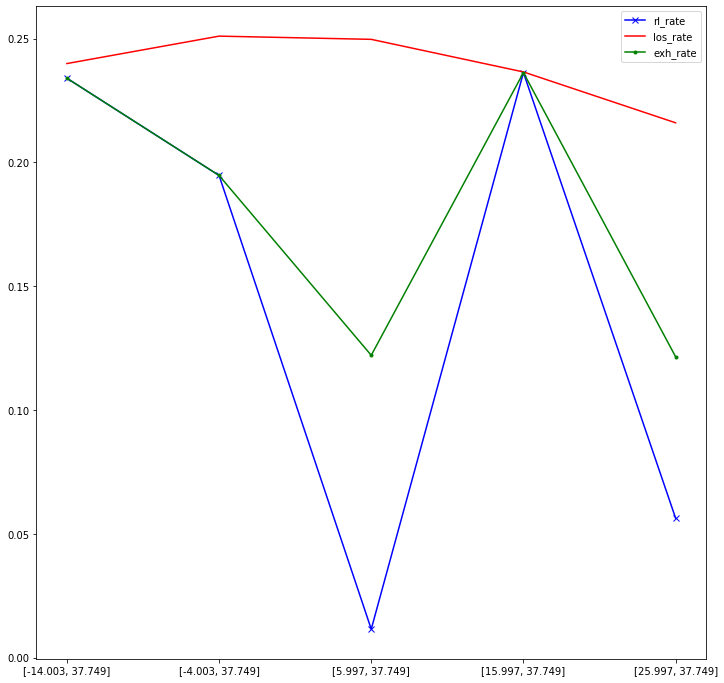

In [10]:
'''
Plot One Episode
'''

#Initialize the environment and state
obs = env.reset()
#print(obs)
state = Gen_State(obs, env)
#print(state)

learnt_rates = []
los_rates = []
exh_rates = []
ue_x = []
for t in count(): 

    #Pick the best learnt action
    action = test_net(state).max(1)[1].view(1,1)
    #print("Learnt values: ", test_net(state).max(1)[1])

    #print("Action: ", action)
    next_obs, reward, done, _ = env.step(action.item())
    #reward = torch.tensor([reward], device=device)

    next_state = Gen_State(next_obs, env)
    #print(obs[0][0])
    curr_loc = (obs[0][0]*np.cos(obs[0][1]), obs[0][0]*np.sin(obs[0][1]))
    next_loc = (next_obs[0][0]*np.cos(next_obs[0][1]), next_obs[0][0]*np.sin(next_obs[0][1]))
    print("Test Episode: {2}, Current Location: {0}, Next Location: {1}".format(curr_loc, next_loc, i_episode))
    print("Learnt values: ", test_net(state))

    #rate measurements
    learnt_rate = env.get_Rate()
    _,los_rate = env.get_Los_Rate(next_obs)
    exh_bdir,exh_rate = env.get_Exh_Rate(next_obs)

    print("exh dir: {0}, learnt bdir: {1}".format(exh_bdir, env.BeamSet[action.item()]))
    print("Learnt Rate: {0}, Exh_Rate: {1}, Los_Rate: {2}".format(learnt_rate, exh_rate, los_rate))

    #Move to the next state
    state = next_state
    obs = next_obs
    ue_x.append(str([np.around(obs[0][0]*np.cos(obs[0][1]), decimals=3), np.around(obs[0][0]*np.sin(obs[0][1]), decimals=3)]))

    learnt_rates.append(learnt_rate)
    los_rates.append(los_rate)
    exh_rates.append(exh_rate)

    if done:
        break


print(ue_x)
fig=plt.figure(figsize=(12,12))
plt.plot(ue_x, learnt_rates,'bx-', ue_x, los_rates, 'r', ue_x, exh_rates, 'g.-')
plt.legend(["rl_rate", "los_rate", "exh_rate"])
plt.show()